In [14]:
# General
import numpy as np
import torch
import torch.nn.functional as F
from importlib import reload
from types import SimpleNamespace
import shap
import torch_geometric
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
from torch_geometric.explain import Explainer, GNNExplainer
from sklearn.metrics import accuracy_score

# Custom
import utils
reload(utils)

import data
reload(data)

import train
reload(train)

import modules
reload(modules)
from modules import GCN, GCN_GNNExplainer, GCN_GraphSVX
from modules import GraphSAGE
from torch_geometric.data import DataLoader
import torch.optim as optim

import explanations
reload(explanations)
from explanations import LIME_explanation, SHAP_explanation

import GraphSVX_explainers
reload(GraphSVX_explainers)
from GraphSVX_explainers import GraphSVX, GraphLIME

%matplotlib inline


# Load model

In [15]:
# Choose model and dataset here
model_name = 'GraphSAGE'
dataset_name = '100K_accts_EASY25'

# Load model, data, and other variables
model_path = f'trained_models/{model_name}_{dataset_name}.pth'

checkpoint = torch.load(model_path)
model_state_dict = checkpoint['model_state_dict']
hyperparameters = checkpoint['hyperparameters']
traindata = checkpoint['traindata']
testdata = checkpoint['testdata']
#feature_names = checkpoint['feature_names']
feature_names = ['sums', 'means', 'medians', 'stds', 'maxs', 'mins', 'in_sum', 'out_sum', 'in_mean', 'out_mean', 'in_median', 'out_median', 'in_std', 'out_std', 'in_max', 'out_max', 'in_min', 'out_min', 'count_in', 'count_out', 'count_days_in_bank', 'count_phone_changes', 'sums_spending', 'means_spending', 'medians_spending', 'stds_spending', 'maxs_spending', 'mins_spending', 'counts_spending']
target_names = checkpoint['target_names']
running_train_loss = checkpoint['running_train_loss']
running_test_loss = checkpoint['running_test_loss']
accuracy = checkpoint['accuracy']

# Initialize model
if model_name == 'GAT':
    in_channels = traindata.x.shape[1]
    hidden_channels = hyperparameters['hidden_channels']
    out_channels = 2
    num_heads = hyperparameters['num_heads']
    dropout = hyperparameters['dropout']
    model = modules.GAT_GraphSVX_foroptuna(in_channels = in_channels, hidden_channels=hidden_channels, out_channels=out_channels, num_heads=num_heads, dropout=dropout)
elif model_name == 'GraphSAGE':
    in_channels = traindata.x.shape[1]
    hidden_channels = hyperparameters['hidden_channels']
    out_channels = 2
    dropout = hyperparameters['dropout']
    seed = hyperparameters['seed']
    torch.manual_seed(seed)
    print('seed: ', seed)
    model = modules.GraphSAGE_GraphSVX_foroptuna(in_channels, hidden_channels, out_channels, dropout=0.2, return_type='logits', seed=seed)

model.load_state_dict(checkpoint['model_state_dict'])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
traindata = traindata.to(device)
testdata = testdata.to(device)
model.eval()

seed:  42


GraphSAGE_GraphSVX_foroptuna(
  (node_emb): Linear(29, 15, bias=True)
  (conv1): SAGEConv(15, 15, aggr=mean)
  (conv2): SAGEConv(15, 15, aggr=mean)
  (conv3): SAGEConv(15, 15, aggr=mean)
  (bn1): BatchNorm(15)
  (bn2): BatchNorm(15)
  (bn3): BatchNorm(15)
  (classifier): Linear(15, 2, bias=True)
  (log_softmax): LogSoftmax(dim=1)
)

# Run GraphSVX

In [16]:
from sklearn.metrics import confusion_matrix

# Set return type of model to log_probas for explainer compatibility
model.set_return_type('log_probas')


model.eval()
with torch.no_grad():
    y_probas = model.forward(testdata.x, testdata.edge_index)
    y_probas = torch.exp(y_probas)
    y_pred = y_probas.cpu().numpy().argmax(axis=1)    
    y_true = testdata.y.cpu().numpy()
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

sar_indices = np.where(y_pred == 1)[0]
print(f'Nodes predicted as SAR: {sar_indices}')

[[75057  1651]
 [18208  5005]]
Nodes predicted as SAR: [    8    28    30 ... 99692 99836 99870]


In [17]:
node_to_explain = sar_indices[0].item()
#testdata_expl, org_to_new_mapping, new_to_org_mapping = utils.build_subgraph(testdata, node_to_explain, 3)
subset_expl, edge_index_expl, _, _ = torch_geometric.utils.k_hop_subgraph(node_to_explain, 3, testdata.edge_index, relabel_nodes=False)
org_to_new_mapping, new_to_org_mapping, edges_new = utils.node_index_mapping(subset_expl, edge_index_expl)
testdata_expl = Data(x = testdata.x[subset_expl], edge_index = edges_new, y = testdata.y[subset_expl])

# n_hops_in_expl = 3
# subset_plot, edge_index_plot, _, _ = torch_geometric.utils.k_hop_subgraph(node_to_explain, n_hops_in_expl, testdata.edge_index, relabel_nodes=False)
# org_to_new_mapping, new_to_org_mapping, edges_new = utils.node_index_mapping(subset_plot, edge_index_plot)
# testdata_plot = Data(x = testdata.x[subset_plot], edge_index = edges_new, y = testdata.y[subset_plot])

# # Unit test for checking that all nodes have neighbours
# n_nodes = testdata_expl.x.shape[0]
# print(n_nodes)
# node_indices = testdata_sub.edge_index.flatten()
# count = 0
# for i in range(n_nodes):
#     if (sum(node_indices == i) == 0):
#         count = count + 1
#         print(count)
# print(f'Total count = {count}')

In [18]:
print(org_to_new_mapping)
print(new_to_org_mapping)

{8: 0, 2265: 1, 2609: 2, 2725: 3, 3423: 4, 3480: 5, 6256: 6, 11405: 7, 13624: 8, 14421: 9, 20623: 10, 21353: 11, 23432: 12, 26068: 13, 31033: 14, 31688: 15, 32321: 16, 38424: 17, 40531: 18, 41754: 19, 43123: 20, 44003: 21, 44024: 22, 44150: 23, 44190: 24, 48961: 25, 51238: 26, 53725: 27, 57846: 28, 58205: 29, 59388: 30, 71932: 31, 76380: 32, 79466: 33, 82396: 34, 86584: 35, 88685: 36, 88800: 37, 89573: 38, 90321: 39, 94485: 40, 96059: 41, 99258: 42}
{0: tensor(8, device='cuda:0'), 1: tensor(2265, device='cuda:0'), 2: tensor(2609, device='cuda:0'), 3: tensor(2725, device='cuda:0'), 4: tensor(3423, device='cuda:0'), 5: tensor(3480, device='cuda:0'), 6: tensor(6256, device='cuda:0'), 7: tensor(11405, device='cuda:0'), 8: tensor(13624, device='cuda:0'), 9: tensor(14421, device='cuda:0'), 10: tensor(20623, device='cuda:0'), 11: tensor(21353, device='cuda:0'), 12: tensor(23432, device='cuda:0'), 13: tensor(26068, device='cuda:0'), 14: tensor(31033, device='cuda:0'), 15: tensor(31688, device=

In [19]:
#Unit test for org_to_new_mapping and new_to_org_mapping
# plt.clf
# print('Testing org_to_new_mapping: ', end = '')
# for i in range(len(subset)):
#     assert org_to_new_mapping[subset[i].item()] == i, "Something is wrong with org_to_new_mapping"
# print('\033[92mTEST PASSED\033[0m')


# print('Testing new_to_org_mapping: ', end = '')
# for i in range(len(subset)):
#     assert new_to_org_mapping[i] == subset[i].item(), "Something is wrong with new_to_org_mapping"
# print('\033[92mTEST PASSED\033[0m')

# Checking if subgraph has any disconnected nodes
# plt.figure()
# G_new = to_networkx(testdata_expl)
# nx.draw(G_new, with_labels=True)

In [20]:
# Printing info about the explained node
#node_to_explain = sar_indices[1].item()
print(f'Explaining node {node_to_explain} which was prediced SAR.')
print(f'The node was predicted SAR (label 1) with probability {y_probas[node_to_explain][1]:.4f}.')
print(f'The true label is {testdata.y[node_to_explain]}.\n')

# NOTE: The subgraph is being extraced above. Maybe move everything here later for clarity
# # Using only the relevant subgraph for quicker computations
# testdata_sub, org_to_new_mapping, new_to_org_mapping = utils.build_subgraph(testdata, node_to_explain, 3)
# testdata_sub = torch_geometric.transforms.ToUndirected()(testdata_sub)

# Running the explainer
testdata_expl = testdata_expl.to('cpu')
model = model.to('cpu')

print(testdata_expl.edge_index.shape)

data = SimpleNamespace()
data.x = testdata_expl.x
data.edge_index  = testdata_expl.edge_index
data.y = testdata_expl.y
data.num_classes = 2
data.num_features = 10
data.num_nodes = testdata_expl.x.shape[0]
data.name = 'test'

explainer = GraphSVX(data, model, True)
explanations = explainer.explain(node_indexes=[0], num_samples=2638, hops = 3, vizu = False)



Explaining node 8 which was prediced SAR.
The node was predicted SAR (label 1) with probability 0.7254.
The true label is 1.

torch.Size([2, 86])
self neighbours tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
        37, 38, 39, 40, 41, 42])
one_hop_neighbours tensor([ 0,  3,  4, 23, 35])


2638it [00:10, 244.03it/s]


r2:  0.9636047965765184
weighted r2:  0.9999899326658742
Explanations include 26 node features and 42 neighbours for this node        for 2 classes
Neighbors are tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
        37, 38, 39, 40, 41, 42])
Model prediction is class 1 with confidence 0.7641517519950867, while true label is 1
Base value 0.02510187047972097 for class  1
Weights for node features:  0.266301682646424 and neighbours:  0.4727574805853042
Most influential features:  3 and neighbours 3
Most influential features:  [(23, 0.04680648045747947), (28, 0.03194209617753184), (2, 0.020870111367875133)]
Most influential neighbours:  [(35, 0.2584849747450525), (3, 0.04949705709055953), (23, 0.021572520132509067)]
Time:  15.185447454452515


Explaining node 8 which was prediced SAR.
The node was predicted SAR (label 1) with probability 0.7254.
The true label is 1.

Number of SVs 68
68
43
43
ding
Length of size_map: 43
Number of nodes in the graph: 43
26


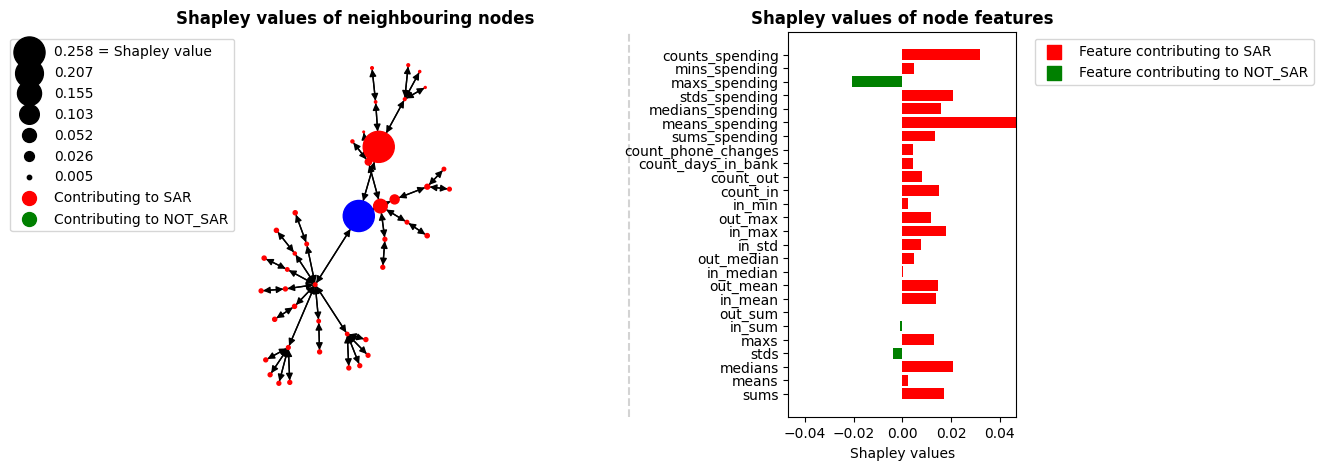

In [21]:
G = to_networkx(testdata_expl)
# nx.draw(G, with_labels=True)

# --- Printing information about node prediction ---
print(f'Explaining node {node_to_explain} which was prediced SAR.')
print(f'The node was predicted SAR (label 1) with probability {y_probas[node_to_explain][1]:.4f}.')
print(f'The true label is {testdata.y[node_to_explain]}.\n')

# --- Extract Shapley values ---
F = explainer.F
D = explanations[0].shape[0] - F
SV = explanations[0]
SV_features = SV[:F]
SV_nodes = SV[F:]

print(f'Number of SVs {len(SV)}')

# Node coloring
color_map = ['blue']
size_map = [500]
labels = {0: node_to_explain}
SV_max = np.abs(SV_nodes).max()
SV_min = np.abs(SV_nodes).min()
for i in range(len(SV_nodes)): 
    SV_node = SV_nodes[i]
    size_map.append(500 * np.abs(SV_node) / SV_max)
    labels[i+1] = new_to_org_mapping[i+1]
    if SV_node < 0:
        color_map.append('green')
    else: 
        color_map.append('red')

print(len(SV))
print(len(size_map))
print(testdata_expl.x.shape[0])

# Create figure
fig = plt.figure(figsize=(10, 5))

# --- Subplot for nodes ---
plt.subplot(1,3,1)

pos = nx.spring_layout(G)
print('ding')
#pos = nx.kamada_kawai_layout(G)
print("Length of size_map:", len(size_map))
print("Number of nodes in the graph:", len(G.nodes))


nx.draw(G, pos=pos, with_labels=False, labels=labels, node_color=color_map, node_size=size_map, font_size=7, font_weight='bold')


# Add legend
plt.scatter([], [], c='black', s=500, label=f'{SV_max:.3f} = Shapley value')
plt.scatter([], [], c='black', s=400, label=f'{4/5*SV_max:.3f}')
plt.scatter([], [], c='black', s=300, label=f'{3/5*SV_max:.3f}')
plt.scatter([], [], c='black', s=200, label=f'{2/5*SV_max:.3f}')
plt.scatter([], [], c='black', s=100, label=f'{1/5*SV_max:.3f}')
plt.scatter([], [], c='black', s=50, label=f'{50/500*SV_max:.3f}')
plt.scatter([], [], c='black', s=10, label=f'{10/500*SV_max:.3f}')
plt.scatter([], [], c='red', s=100, label='Contributing to SAR')
plt.scatter([], [], c='green', s=100, label='Contributing to NOT_SAR')
plt.legend(bbox_to_anchor=(0, 1),loc='upper right')

plt.title('Shapley values of neighbouring nodes',fontweight='bold')

# --- Add vertical line to separate the plots ---
plt.subplot(1, 3, 2)
plt.axvline(x=5, color='lightgray', linestyle='--')
plt.axis('off')  # Turn off axis

# --- Shapley Values for features ---
plt.subplot(1, 3, 3)
# Extract features that are used in the explanation, and get their original feature names
feat_idx, discarded_feat_idx = explainer.feature_selection(0, "Expectation") # Using 0 here since 0 is node_to_explain in the subgraph
print(len(feat_idx))
feature_names_in_explanation = [feature_names[i] for i in feat_idx]

colors = ['green' if e < 0 else 'red' for e in SV_features]
plt.barh(range(len(SV_features)), SV_features, color=colors)
xlim = np.abs(SV_features).max()
plt.xlim(-xlim, xlim)
plt.yticks(range(len(SV_features)), feature_names_in_explanation)
plt.xlabel('Shapley values')
plt.scatter([], [], c='red', s=100, marker = 's', label='Feature contributing to SAR')
plt.scatter([], [], c='green', s=100, marker = 's', label='Feature contributing to NOT_SAR')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Shapley values of node features',fontweight='bold')

# --- Plot figures ---
plt.show()

No shapley value bigger than 0.26000000000000006. Stopping.


Text(0, 0.5, 'Number of suspicious neighbours')

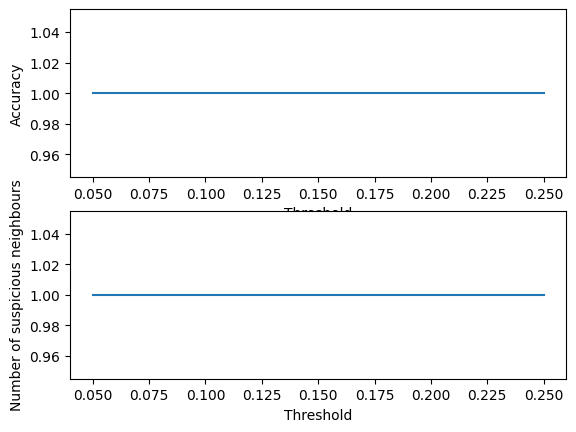

In [22]:
import numpy as np

accuracy = []
n_sus_neighbours = []
threshholds = np.arange(0.05,0.5,0.01)
for thresh in threshholds:
    suspicious_neighbours_orgidx = []
    suspicious_neighbours_sv = []
    suspicious_neighbours_ypred = []
    suspicious_neighbours_y = []
    
    for node_idx, sv in enumerate(SV_nodes):
        
        node_idx = node_idx + 1 #sv at position 0 corresponds to node 1 (since node 0 is not assigned a Shapley value)
        if sv > thresh:
            #suspicious_neighbours_orgidx.append(new_to_org_mapping[node_idx].item())
            suspicious_neighbours_orgidx.append(node_idx)
            suspicious_neighbours_sv.append(sv)
            suspicious_neighbours_ypred.append(1)
            suspicious_neighbours_y.append(testdata_expl.y[node_idx].item())

    if len(suspicious_neighbours_orgidx) == 0:
        print(f'No shapley value bigger than {thresh}. Stopping.')
        break
    
    tmp = accuracy_score(suspicious_neighbours_y, suspicious_neighbours_ypred)
    accuracy.append(tmp)
    n_sus_neighbours.append(len(suspicious_neighbours_ypred))

    # for orgidx, sv, y in zip(suspicious_neighbours_orgidx, suspicious_neighbours_sv, suspicious_neighbours_y):
    #     print(f'Node {orgidx} suspicious neighbour with Shapley Value = {sv} and true label {y}')
    
    # print(suspicious_neighbours_ypred)
    # print(suspicious_neighbours_y)
    

threshholds = threshholds[0:len(accuracy)]

plt.figure()
plt.subplot(2,1,1)
plt.plot(threshholds, accuracy)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.subplot(2,1,2)
plt.plot(threshholds, n_sus_neighbours)
plt.xlabel('Threshold')
plt.ylabel('Number of suspicious neighbours')
# for  in range(len(suspicious_neighbours)):
#     print(f'Node {} suspicious neighbour with Shapley Value = {SV_nodes[node_idx]:.4f} and true label {suspicious_neighbours_y[node_idx]}')



In [23]:
# Create dictionary with feature importance:

feature_importance_GraphSVX = {feat_name : feat_val for feat_name, feat_val in zip(feature_names_in_explanation, SV_features)}

for feat_name in feature_importance_GraphSVX.keys():
    print(f'{feat_name}: {feature_importance_GraphSVX[feat_name]:.4f}')

sums: 0.0172
means: 0.0023
medians: 0.0209
stds: -0.0038
maxs: 0.0129
in_sum: -0.0011
out_sum: -0.0002
in_mean: 0.0138
out_mean: 0.0145
in_median: 0.0002
out_median: 0.0049
in_std: 0.0076
in_max: 0.0181
out_max: 0.0117
in_min: 0.0023
count_in: 0.0150
count_out: 0.0081
count_days_in_bank: 0.0045
count_phone_changes: 0.0045
sums_spending: 0.0134
means_spending: 0.0468
medians_spending: 0.0159
stds_spending: 0.0208
maxs_spending: -0.0208
mins_spending: 0.0049
counts_spending: 0.0319


# Run GNNExplainer

Node to explain: 5


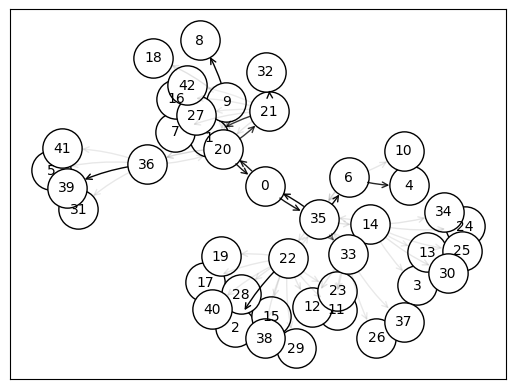

In [21]:
print(f'Node to explain: {node_to_explain}')

model.cpu()
testdata_expl.cpu()

exp_GNN = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='probs',  # Model returns log probabilities.
    ),
)

explanation = exp_GNN(testdata_expl.x, testdata_expl.edge_index, index=0)

#explanation.visualize_feature_importance(top_k=10)
explanation.visualize_graph()

# Run LIME and SHAP

Starting forward_NFVinput...
Setting return type of forward pass to "logits" so that forward_NFVinput returns "probas"...
all_idx_start: [0]
all_idx_stop: [5000]
num_samples: 5000
n_iters: 1
n_samples_per_iter: 5001
Loading data iter 1/1
Finished.


backgrounddata.x.shape[1]:  29
len(feature_names):  29
Starting forward_NFVinput...
Setting return type of forward pass to "logits" so that forward_NFVinput returns "probas"...
all_idx_start: [0]
all_idx_stop: [1]
num_samples: 1
n_iters: 1
n_samples_per_iter: 2
Loading data iter 1/1
Finished.
Starting forward_NFVinput...
Setting return type of forward pass to "logits" so that forward_NFVinput returns "probas"...
all_idx_start: [0]
all_idx_stop: [1]
num_samples: 1
n_iters: 1
n_samples_per_iter: 2
Loading data iter 1/1
Finished.
average prediction:  [[0.3689195]]
Starting forward_NFVinput...
Setting return type of forward pass to "logits" so that forward_NFVinput returns "probas"...
all_idx_start: [0]
all_idx_stop: [1]
num_samples: 1
n_iters: 1
n_samples_per_iter: 2
Loading data iter 1/1
Finished.
Starting forward_NFVinput...
Setting return type of forward pass to "logits" so that forward_NFVinput returns "probas"...
all_idx_start: [0]
all_idx_stop: [2106]
num_samples: 2106
n_iters: 1
n_

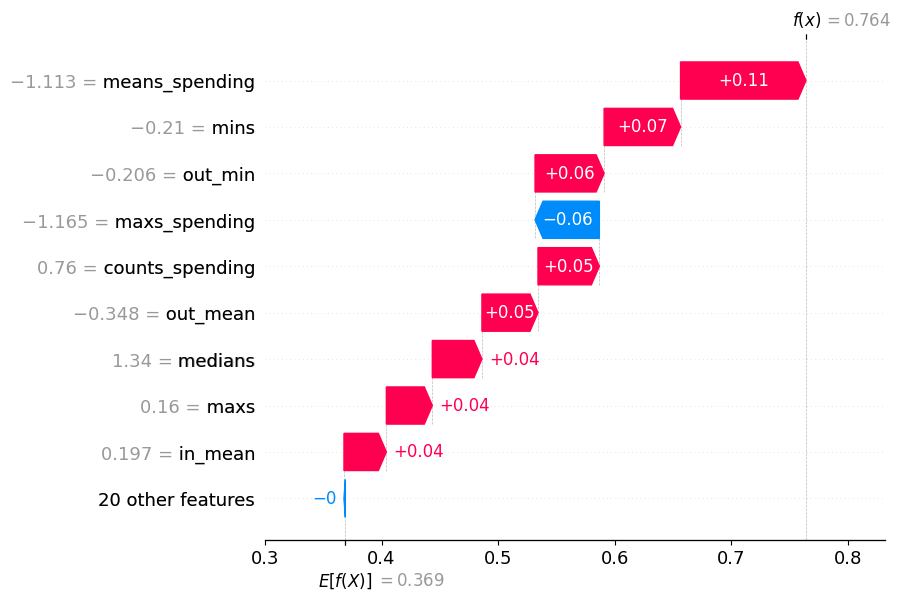

In [25]:
model = model.to('cuda:0')
testdata_expl = testdata_expl.to('cuda:0')

# --- LIME ---
num_features = 29
class_prob_fn = model.forward_NFVinput

# Prepare the model for handling the LIME explainer
model.set_test_data(testdata_expl)
model.set_node_to_explain(org_to_new_mapping[node_to_explain])
model.set_masking_mode('all_nodes')

exp_LIME = LIME_explanation(node_to_explain = node_to_explain,
                                    num_features = num_features,
                                    class_prob_fn = class_prob_fn,
                                    testdata = testdata,
                                    feature_names = feature_names,
                                    target_names = target_names)

exp_LIME.show_in_notebook(show_table=True, show_all=False)


# --- SHAP ---
K = 20
class_prob_fn = model.forward_NFVinput

exp_SHAP = SHAP_explanation(node_to_explain = node_to_explain,
                                         class_prob_fn = class_prob_fn,
                                         backgrounddata = traindata,
                                         explaindata = testdata,
                                         feature_names = feature_names,
                                         K = K)

shap.plots.waterfall(exp_SHAP[0])

In [23]:
# Create dictionary with feature importance for LIME:
feature_importance_LIME = {feature_names[feat_index] : feat_val for (feat_index, feat_val) in exp_LIME.local_exp[1]}

for feat_name in feature_importance_LIME.keys():
    print(f'{feat_name}: {feature_importance_LIME[feat_name]:.4f}')

print()

# Create dictionary with feature importance for SHAP:
feature_importance_SHAP = {feat_name : feat_val for feat_name, feat_val in zip(feature_names, exp_SHAP[0].values)}

for feat_name in feature_importance_SHAP.keys():
    print(f'{feat_name}: {feature_importance_SHAP[feat_name]:.4f}')

n_unique_out: -0.0880
mean: -0.0552
in_max: 0.0510
count_phone_changes: -0.0496
out_median: 0.0476
n_unique_in: 0.0444
sum: 0.0294
out_min: -0.0269
max: 0.0258
std: 0.0237

sum: 0.0042
mean: -0.0569
median: 0.0005
std: 0.0076
max: 0.0016
min: -0.0052
in_sum: 0.0186
out_sum: -0.0167
in_mean: 0.0000
out_mean: -0.0071
in_median: -0.0007
out_median: 0.0188
in_std: 0.0017
out_std: 0.0016
in_max: 0.0037
out_max: 0.0009
in_min: -0.0018
out_min: -0.0146
count_in: 0.0183
count_out: -0.0123
n_unique_in: 0.0540
n_unique_out: -0.0266
count_days_in_bank: -0.0029
count_phone_changes: 0.0000
sum_spending: 0.0040
mean_spending: -0.0030
median_spending: 0.0018
std_spending: 0.0017
max_spending: 0.0034
min_spending: 0.0002
count_spending: 0.0000


# Final check of feature importance dictionaries

In [24]:
plt.figure()
# Extract features that are used in the explanation, and get their original feature names
feat_idx, discarded_feat_idx = explainer.feature_selection(0, "Expectation") # Using 0 here since 0 is node_to_explain in the subgraph
print(len(feat_idx))
feature_names_in_explanation = [feature_names[i] for i in feat_idx]

colors = ['green' if e < 0 else 'red' for e in SV_features]
plt.barh(range(len(SV_features)), SV_features, color=colors)
xlim = np.abs(SV_features).max()
plt.xlim(-xlim, xlim)
plt.yticks(range(len(SV_features)), feature_names_in_explanation)
plt.xlabel('Shapley values')
plt.scatter([], [], c='red', s=100, marker = 's', label='Feature contributing to SAR')
plt.scatter([], [], c='green', s=100, marker = 's', label='Feature contributing to NOT_SAR')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Shapley values of node features',fontweight='bold')

# --- Plot figures ---
plt.show()

for feat_name in feature_importance_GraphSVX.keys():
    print(f'{feat_name}: {feature_importance_GraphSVX[feat_name]:.4f}')

AttributeError: 'Explainer' object has no attribute 'feature_selection'

<Figure size 640x480 with 0 Axes>

In [ ]:
exp_LIME.show_in_notebook(show_table=True, show_all=False)

for feat_name in feature_importance_LIME.keys():
    print(f'{feat_name}: {feature_importance_LIME[feat_name]:.4f}')


n_unique_out: -0.0941
in_max: 0.0594
mean: -0.0524
n_unique_in: 0.0405
out_min: -0.0385
out_median: 0.0341
max: 0.0265
std: 0.0245
sum: 0.0230
count_in: 0.0226


In [ ]:
shap.plots.waterfall(exp_SHAP[0])

for feat_name in feature_importance_SHAP.keys():
    print(f'{feat_name}: {feature_importance_SHAP[feat_name]:.4f}')

# Sandbox

In [15]:
exp_LIME.score


0.16141195856164436